## Description

Implement a standard echo state network (ESN) model. This does not include feedback from the output and leaky-integrator neurons. Implement training of the read-out weights by means of ridge regression. Perform experiments and comment the results by considering a _k_ step ahead forecasting task on the "2sine" and "lorentz" time series data provided to you together with this notebook. Evaluate the impact of relevant hyper-parameters on the results, including the reservoir size and the amount of training data used for optimizing the read-out weights. Finally, discuss the effects of using different forecasting horizons on the overall performance of the model.

### K step ahead forecasting
A _k_ step ahead forecasting task consists of predicting the value of a time series at time $t+k$ by using the value of the time series at time $t$, where $k\geq1$ is called forecasting horizon.
In general, the predicted value is always unidimensional (i.e. a single number). However, it is possible to use multiple input values in order to improve the results. Notably, once _k_ is decided, the output to be predicted is the value of the time series at time $t+k$, and the input may be a vector containing values of the times series at time $t, t-1, \dots, t-n$, where $n\geq0$ is defined by the user and sets the dimensionality of the input vector.

reference material: http://www.scholarpedia.org/article/Echo_state_network
# Build the ESN model

A fuction named **ESN** was created to implement the standard echo state network model.
The state-update equation reads:
$$x_{t+1} = \phi(W_r x_t + W_i u_{t+1}) $$
where $x$ denotes the ESN state over time and $u$ denotes the input. The ESN output is produced as follows:
$$y_{t} = W_o x_t $$
i.e. the output is a linear function of the state (the bias may be included in the weights, as usual).

The optimization of the read-out weights ($W_{}$) is performed by means of the regularized least-square method: 
$$W_{o} = (X^TX + \lambda I)^{-1} X^Tt$$
where $X$ is a matrix containing all states generated during training, $I$ is a $N_r \times N_r$ identity matrix, $t$ is the target data. 

The Mean-squared Error(*MSE*) is used to assess the prediction performance. 

$$MSE = <||t-z||^2>$$

where $z$ is the predicted value and <> indicates average over time.
    


In [906]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
# make sure plots are correctly displayed in the notebook
%matplotlib inline

## Setup data for Training, Testing and Validating

In [907]:
# start with 2sin data and apply the same step for lorenz data
data = np.loadtxt('2sin.txt')

# split data in 60:20:20 for train:test:valid data


def setup(data, k):
    p1 = int(0.6*len(data))
    p2 = int(0.8*len(data))
    X_train = data[:p1]
    Y_train = data[np.newaxis, k:p1+k]
    X_test = data[p1:p2]
    Y_test = data[np.newaxis, p1+k:p2+k]
    X_valid = data[p2:]
    Y_valid = data[np.newaxis, p2+k:]
    return X_train, X_test, X_valid, Y_train, Y_test, Y_valid


## Initialize model parameters W_i, W_r, Spectral Radius

![spectral_radius](spectral_radius.png)

In [908]:
np.random.seed(1)
res = 50
inputSize = 1


def init_params(res, inputSize):
    W_r = np.random.uniform(-1, 1, (res, res))
    W_i = np.random.uniform(-1, 1, (res, inputSize+1))
    spec_rad = max(abs(linalg.eig(W_r)[0]))
    W_r *= 1/spec_rad
    return W_i, W_r


In [909]:
k = 1
X_train, X_test, X_valid, Y_train, Y_test,  Y_valid = setup(data, k)
W_i, W_r = init_params(res, inputSize)


## Collect the resulting N states x_i in matrix X (N_r x N)

![esn](readout.png)

In [910]:

X = np.zeros((res+inputSize, len(X_train)))
x = np.zeros((res, inputSize))


def collect_matrix(x):
    for t in range(len(X_train)):
        u = X_train[t]
        x = np.tanh(np.dot(W_r, x) + np.dot(W_i, np.vstack((1, u))))
        X[:, t] = np.vstack((u, x))[:, 0]
    return X, x


X, x = collect_matrix(x)


## Train weight output (one-shot)

![rr](rr.png)

In [911]:
reg = 0.01
def ridge_regression(reg):
    W_o = np.dot(np.dot(Y_train,X.T), linalg.inv(np.dot(X,X.T) + reg*np.eye(res+inputSize)))
    return W_o
W_o = ridge_regression(reg)    
W_o.shape


(1, 51)

## Run testing data on ESN model


In [912]:

data_length = len(X_test)

Z = np.zeros((1, data_length))


def run_esn(data_length,x):
    u = X_test[0]
    for t in range(data_length-k):
        x = np.tanh(np.dot(W_r, x) + np.dot(W_i, np.vstack((1, u))))
        z = np.dot(W_o, np.vstack((u, x)))
        Z[:, t] = z
        u = X_test[t+k]
    return Z, x

Z, x = run_esn(data_length,x)


## Assess predictive performance
### Compute Mean-Square-Error (MSE)
![mse](mse.png)

In [913]:

T = Y_test # target
def get_mse():
    mse = sum(np.square(T[0,:data_length] - Z[0,:data_length]))/data_length
    return mse
mse = get_mse()
print('MSE = ' + str(mse))


MSE = 0.0007701424587518893


### Compute Normalized Root MSE (NRMSE)
Performance is normalized thus allow to compare with other data (using this ESN model)

![nrmse](nrmse.png)

In [914]:

def get_nrmse():
    nrmse = np.sqrt(mse)/np.var(T)
    return nrmse

nrmse = get_nrmse()
print('NRMSE = ' + str(nrmse))


NRMSE = 0.02805325296526419


## Plot the graph

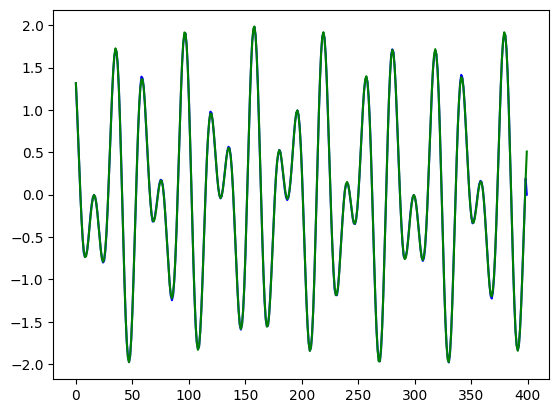

In [915]:
plt.figure().clear()
plt.plot(Z.T, color='b')
plt.plot(Y_test.T, 'g')

## Report when running 2sin dataset

### Running with different k value (other hyperparameters kept the same)

reg = 0.001, reservoir size = 50

- k = 1: MSE = 0.00077, NRMSE = 0.02805
- k = 5: MSE = 1.62493, NRMSE = 1.28870
- k = 25: MSE = 5.08476, NRMSE = 2.28545

### Running with different reservoir size 

reg = 0.001, k = 5

- res = 5: MSE = 1.01700, NRMSE = 1.01952
- res = 50: MSE = 1.62493, NRMSE = 1.28870
- res = 500: MSE = 1.88065, NRMSE = 1.38640

## Report when running Lorenz dataset

### Running with different k value

reg = 0.001, reservoir size = 50

- k = 1: MSE = 0.09841, NRMSE = 0.00492
- k = 5: MSE = 1.26688, NRMSE = 0.01768
- k = 25: MSE = 50.08787, NRMSE = 0.11273

### Running with different reservoir size 

reg = 0.001, k = 5

- res = 5: MSE = 0.40059, NRMSE = 0.00994
- res = 50: MSE = 1.26688, NRMSE = 0.01768
- res = 500: MSE = 2.48714, NRMSE = 0.02477 

## Conclusion 

### On hyperparameter k 
- We can see from 2 dataset if the k-step forecasting are increase then the prediction of the model decrease.

### On reservoir size 
- We see that increase in reservoir size does in fact decrease the performance